# Leaf Dataset

Le dataset complet est disponible sur <a href="https://www.kaggle.com/c/leaf-classification/data" target="_blank">Kaggle</a>
Pour cette exercice, nous avons deja un dataset nettoyer donc on va passer très rapidement au travers

In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

# Exploration

In [20]:
train_set = pd.read_csv("train.csv")

seed = 42 # pour avoir toujours le meme random seed

In [21]:
print(train_set.head(), "\n")
print(train_set.describe(), "\n")
print(train_set.info(), "\n")
print(train_set["species"].value_counts())

   id                species   margin1   margin2   margin3   margin4  \
0   1            Acer_Opalus  0.007812  0.023438  0.023438  0.003906   
1   2  Pterocarya_Stenoptera  0.005859  0.000000  0.031250  0.015625   
2   3   Quercus_Hartwissiana  0.005859  0.009766  0.019531  0.007812   
3   5        Tilia_Tomentosa  0.000000  0.003906  0.023438  0.005859   
4   6     Quercus_Variabilis  0.005859  0.003906  0.048828  0.009766   

    margin5   margin6   margin7  margin8    ...      texture55  texture56  \
0  0.011719  0.009766  0.027344      0.0    ...       0.007812   0.000000   
1  0.025391  0.001953  0.019531      0.0    ...       0.000977   0.000000   
2  0.003906  0.005859  0.068359      0.0    ...       0.154300   0.000000   
3  0.021484  0.019531  0.023438      0.0    ...       0.000000   0.000977   
4  0.013672  0.015625  0.005859      0.0    ...       0.096680   0.000000   

   texture57  texture58  texture59  texture60  texture61  texture62  \
0   0.002930   0.002930   0.03515

Bon points :
<li>On a que des données numérique ce qui simplifie la mise en place du modèle. </li>
<li>On n'a pas de points manquants et ils sont tous en float64 (sauf la classe qui est objet et l'incrémentation en int)</li>
<li>Le dataset est très léger ce qui va permettre de ne pas avoir de soucis avec la mémoire. </li>

1 bémol à prendre en considération
<li>les echelles ne sont pas respectées (certains max sont à 0.08 et d'autres a 0.57). </li>

On va donc normaliser le dataset. Dans ce cas on a 2 choix :
<li>le Min-Max scalar</li>
<li>le Standard Scaler</li>

Dans ce cas la, le plus censé est le Min-Max Scalar car toutes nos features sont positives initialement.

Premièrement, separons les labels des variables. On peut ensuite separer notre dataset de test et d'entrainement

In [22]:
X = train_set.drop(["id", "species"], axis=1)
y = train_set["species"]

Voila maintenant on peut modifier nos données et les separer en test et training

In [23]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

(990, 192)


# Baseline de performances

On peut maintenant mettre en place le KNN en testant la precision sur le test set pour differentes valeurs de n_neighbors. Comme le modèle est léger, on peut tester "par bruteforce" 19 valeurs

Erreur: 0.020202
Erreur: 0.040404
Erreur: 0.020202
Erreur: 0.030303
Erreur: 0.020202
Erreur: 0.040404
Erreur: 0.045455
Erreur: 0.055556
Erreur: 0.075758
Erreur: 0.090909
Erreur: 0.126263
Erreur: 0.111111
Erreur: 0.131313
Erreur: 0.156566
Erreur: 0.181818
Erreur: 0.217172
Erreur: 0.232323
Erreur: 0.237374
Erreur: 0.242424


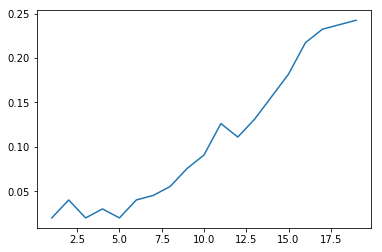

In [6]:
range_x = list(range(1, 20))
range_y = []
for i in range_x:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    error = 1 - knn.score(X_test, y_test)
    print('Erreur: %f' % error)
    range_y.append(error)
plt.plot(range_x, range_y)
plt.show()

Donc il faut plutot rester en dessus de 5 voisins. Les meilleurs resultats étant 3 ou 5, on peut prendre ces valeurs comme baseline. On a donc une baseline de <b>2% d'erreurs</b>.

# Mise en place d'un SVM multiclasse

Comme on a 5 classes (voir colonnes species) on peut tester le OVR et le OVO. Le OVR aura 5 classifieurs (1 classifieur par classe) alors que le OVO aura (5*4)/2 = 10 classifieurs

On va utiliser GridSearchCV pour tester différents paramètres pour les modèles. Or GridSearchCV utilise majoritairement la validation par folds. Du coup on ne va plus utiliser le dataset de train mais plutot avoir 5 folds. Le modèle devant prédire la bonne classe, on va evaluer le modèle sur son score (le nb de classe bien evalué/nb de classe evalués).

In [7]:
grid = [{
            "penalty" : ["l1", "l2"], 
            "multi_class" : ["ovr", "crammer_singer"], 
            "C" : [0.01, 0.1, 1, 10],
            # "tol" : [0.1, 0.01, 0.001, 0.0001]    # Commenté car il ne change pas les resultats et rend le training 4x plus lent
        }]
clf = LinearSVC(dual=False, random_state=seed)      # dual=False car on a plus de samples que de features (cf la doc) 
grid_search = GridSearchCV(clf, grid, cv=5, scoring="accuracy")
grid_search.fit(X, y)  # X et y est le full dataset transformé

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'multi_class': ['ovr', 'crammer_singer'], 'C': [0.01, 0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

On a donc maintenant notre grid search. On peut donc afficher les score par rapport au paramètres. On peut aussi afficher cela avec un graph.

0.010101010101 {'C': 0.01, 'multi_class': 'ovr', 'penalty': 'l1'}
0.961616161616 {'C': 0.01, 'multi_class': 'ovr', 'penalty': 'l2'}
0.980808080808 {'C': 0.01, 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.980808080808 {'C': 0.01, 'multi_class': 'crammer_singer', 'penalty': 'l2'}
0.313131313131 {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l1'}
0.988888888889 {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2'}
0.984848484848 {'C': 0.1, 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.984848484848 {'C': 0.1, 'multi_class': 'crammer_singer', 'penalty': 'l2'}
0.966666666667 {'C': 1, 'multi_class': 'ovr', 'penalty': 'l1'}
0.991919191919 {'C': 1, 'multi_class': 'ovr', 'penalty': 'l2'}
0.992929292929 {'C': 1, 'multi_class': 'crammer_singer', 'penalty': 'l1'}
0.992929292929 {'C': 1, 'multi_class': 'crammer_singer', 'penalty': 'l2'}
0.969696969697 {'C': 10, 'multi_class': 'ovr', 'penalty': 'l1'}
0.990909090909 {'C': 10, 'multi_class': 'ovr', 'penalty': 'l2'}
0.991919191919 {'C': 10, 'mult

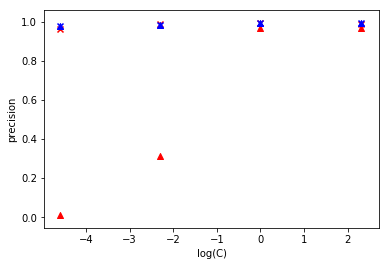

In [8]:
evaluation = grid_search.cv_results_
for score, param in zip(evaluation["mean_test_score"], evaluation["params"]):
    print(score, param)
    if param["multi_class"] == "ovr":
        c="r"
    else:
        c="b"
    if param["penalty"] == "l1":
        m="^"
    else:
        m="x"
    plt.scatter(math.log(param["C"]), score, c=c, marker=m)  # on passe au log pour "ecraser" le x-axis

plt.ylabel("precision")
plt.xlabel("log(C)")
plt.show()

On peut remarque que dans ce cas, le One vs One fonctionne mieux que le One vs All pour presque tous les paramètres.

On peut donc maintenant récupérer le meilleur modèle avec ses paramètres

In [9]:
best_model = grid_search.best_estimator_

On a donc des moyenne sur un K-fold de taille 5. Ce que l'on peut faire pour vraiment comparer le modèle est de le tester sur le meme test_set que celui du KNN. On aura donc une vraie comparaison 

In [10]:
best_model.score(X_test, y_test)

1.0

Wow! <b>par chance</b> on a 100% de reussite car on sait que sur le dataset complet on a 99.29%. On a donc un modèle beacoup plus précis que le KNN.

## Bonus visualisation

Maintenant pour visualiser le resultat on va devoir convertir les classes en couleur pour matplotlib. Cela va se faire avec la fonction label Encoder de Scikit Learn et map de matplotlib

In [11]:
le = LabelEncoder()
encoded_label = le.fit_transform(y)
int_val = le.transform(le.classes_)
for classe, numero in list(zip(le.classes_, int_val)):
    print(classe, "\t\t", numero)

Acer_Capillipes 		 0
Acer_Circinatum 		 1
Acer_Mono 		 2
Acer_Opalus 		 3
Acer_Palmatum 		 4
Acer_Pictum 		 5
Acer_Platanoids 		 6
Acer_Rubrum 		 7
Acer_Rufinerve 		 8
Acer_Saccharinum 		 9
Alnus_Cordata 		 10
Alnus_Maximowiczii 		 11
Alnus_Rubra 		 12
Alnus_Sieboldiana 		 13
Alnus_Viridis 		 14
Arundinaria_Simonii 		 15
Betula_Austrosinensis 		 16
Betula_Pendula 		 17
Callicarpa_Bodinieri 		 18
Castanea_Sativa 		 19
Celtis_Koraiensis 		 20
Cercis_Siliquastrum 		 21
Cornus_Chinensis 		 22
Cornus_Controversa 		 23
Cornus_Macrophylla 		 24
Cotinus_Coggygria 		 25
Crataegus_Monogyna 		 26
Cytisus_Battandieri 		 27
Eucalyptus_Glaucescens 		 28
Eucalyptus_Neglecta 		 29
Eucalyptus_Urnigera 		 30
Fagus_Sylvatica 		 31
Ginkgo_Biloba 		 32
Ilex_Aquifolium 		 33
Ilex_Cornuta 		 34
Liquidambar_Styraciflua 		 35
Liriodendron_Tulipifera 		 36
Lithocarpus_Cleistocarpus 		 37
Lithocarpus_Edulis 		 38
Magnolia_Heptapeta 		 39
Magnolia_Salicifolia 		 40
Morus_Nigra 		 41
Olea_Europaea 		 42
Phildelphu

Voila on a donc 1 numéro par classe. Le Label encoder permet aussi de retourner du numéro au nom de la classe avec inverse_transform. On va donc maintenant projeter le dataset dans ses 2 principales dimensions avec le PCA. Les 2 premieres dimensions seront utilisées pour placer les points du dataset. Ensuite on va générer une grille pour parcourir tous les x, y et determiner leurs labels. Ensuite on pourra colorer les zone de la couleur evalué par notre modèle

In [12]:
# # projection du dataset
# pca = PCA(n_components=2)
# X_proj = pca.fit_transform(X)

# #on garde que 100 pts par lisibilité
# X_proj = X_proj[:100, :]
# y_2 = y[:100]

# # Creation d'une grille projeté sur les 2 principaux axes
# multiples = np.arange(-5, 5, 0.1)
# first_axis = multiples[:, np.newaxis] * pca.components_[0, :]
# second_axis = multiples[:, np.newaxis] * pca.components_[1, :]
# grid = first_axis[np.newaxis, :, :] + second_axis[:, np.newaxis, :]

# # on l'applati pour determiner les classes et la transformer en entier pour la couleur
# flat_grid = grid.reshape(-1, 64*3)  # car on avait 192 features a la base
# Z = best_model.predict(flat_grid)
# Z = le.transform(Z)
# Z = Z.reshape(grid.shape[:-1]) # on repasse le vecteur en matrice

# # on affiche les zones
# plt.contourf(multiples, multiples, Z, cmap=plt.cm.Paired)

# # on transforme les classe des points en entier pour le scatter avec les 100 pts choisis
# y_color = le.transform(y_2)    
# plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y_color, cmap=plt.cm.Paired, edgecolors=(0, 0, 0))

# plt.show()

Je pense qu'il y a une erreur sur cette représentation (surement lors de la projection sur les axes principaux du PCA). L'objectif de base était de représenter les zones de classification du modèle et voir que les points ont la meme couleur que la couleur de la zone. Cependant ca ne marche pas... Désolé :(

# Evaluation

In [24]:
test = pd.read_csv("test.csv")
eval_format = pd.read_csv("sample_submission.csv")

In [25]:
print(test.head())
print(eval_format.head())

   id   margin1   margin2   margin3   margin4   margin5   margin6   margin7  \
0   4  0.019531  0.009766  0.078125  0.011719  0.003906  0.015625  0.005859   
1   7  0.007812  0.005859  0.064453  0.009766  0.003906  0.013672  0.007812   
2   9  0.000000  0.000000  0.001953  0.021484  0.041016  0.000000  0.023438   
3  12  0.000000  0.000000  0.009766  0.011719  0.017578  0.000000  0.003906   
4  13  0.001953  0.000000  0.015625  0.009766  0.039062  0.000000  0.009766   

   margin8   margin9    ...      texture55  texture56  texture57  texture58  \
0      0.0  0.005859    ...       0.006836   0.000000   0.015625   0.000977   
1      0.0  0.033203    ...       0.000000   0.000000   0.006836   0.001953   
2      0.0  0.011719    ...       0.128910   0.000000   0.000977   0.000000   
3      0.0  0.003906    ...       0.012695   0.015625   0.002930   0.036133   
4      0.0  0.005859    ...       0.000000   0.042969   0.016602   0.010742   

   texture59  texture60  texture61  texture62  tex

In [50]:
iid = test["id"]
X = test.drop(["id"], axis=1)

In [51]:
X = scaler.transform(X)

In [52]:
y = best_model.predict(X)
print(y)

['Quercus_Agrifolia' 'Quercus_Afares' 'Acer_Circinatum' 'Castanea_Sativa'
 'Alnus_Viridis' 'Acer_Opalus' 'Acer_Opalus' 'Eucalyptus_Glaucescens'
 'Quercus_Variabilis' 'Acer_Rufinerve' 'Phildelphus' 'Quercus_Pontica'
 'Quercus_Pubescens' 'Alnus_Cordata' 'Quercus_Alnifolia' 'Populus_Nigra'
 'Populus_Grandidentata' 'Quercus_Phillyraeoides' 'Alnus_Sieboldiana'
 'Quercus_Palustris' 'Quercus_Crassipes' 'Quercus_Infectoria_sub'
 'Quercus_Chrysolepis' 'Quercus_Rhysophylla' 'Acer_Circinatum'
 'Quercus_Nigra' 'Eucalyptus_Glaucescens' 'Arundinaria_Simonii'
 'Liquidambar_Styraciflua' 'Quercus_Nigra' 'Quercus_Brantii'
 'Quercus_Pontica' 'Prunus_Avium' 'Quercus_Afares' 'Acer_Palmatum'
 'Liriodendron_Tulipifera' 'Alnus_Viridis' 'Quercus_Castaneifolia'
 'Liriodendron_Tulipifera' 'Tilia_Platyphyllos' 'Acer_Rufinerve'
 'Ginkgo_Biloba' 'Acer_Rufinerve' 'Acer_Saccharinum' 'Quercus_Palustris'
 'Quercus_Nigra' 'Lithocarpus_Edulis' 'Cornus_Controversa'
 'Tilia_Tomentosa' 'Callicarpa_Bodinieri' 'Betula_Pendula

In [53]:
a = pd.Series(y)

In [54]:
a = pd.get_dummies(a)

In [55]:
# a.insert(0, "id", iid)
# print(a)
a["id"] = iid

In [56]:
print(a)

     Acer_Capillipes  Acer_Circinatum  Acer_Mono  Acer_Opalus  Acer_Palmatum  \
0                  0                0          0            0              0   
1                  0                0          0            0              0   
2                  0                1          0            0              0   
3                  0                0          0            0              0   
4                  0                0          0            0              0   
5                  0                0          0            1              0   
6                  0                0          0            1              0   
7                  0                0          0            0              0   
8                  0                0          0            0              0   
9                  0                0          0            0              0   
10                 0                0          0            0              0   
11                 0                0   

In [ ]:
a.to_csv()